In [1]:
%load_ext autoreload
%autoreload 2

import roicat

# Intro: Types of data
This notebook will demonstrate how to import data of various types into a data object which can be used for classification or tracking.\
There are 5 types of data that are possible to collect into a data class:

### 1. **ROI spatial footprints**: 
- The mask of an ROI in the full field of view.
- Used for **tracking only**.
- Stored as sparse arrays.

### 2. **ROI images**: 
- Images of individual masks. 
- Used for **tracking AND classifiaction**.
- Stored as dense arrays.

### 3. **ROI class labels**: 
- Labels of the classification of each ROI. 
- Used for **classification only**.
- Stored as integer arrays.

### 4. **Field of view (FOV) images**:
- Images of the average field of view of the imaging plane.
- Used for **tracking only**.
- Stored as dense arrays.

### 5. **Metadata**:
- Information about the field of view size, resolution, etc.
- Used for **tracking and classification**
- Stored as attributes in the data class.

___

# Demo: Import custom ROI_images and associated labels

In [2]:
from pathlib import Path

import numpy as np
import scipy.sparse
import einops

### Load ROI_images data and labels data

Load some custom data of ROI images that are stored as a sparse array.\
The sparse array is a 2D sparse matrix with `shape = (n_ROIs, height*width)`

In [50]:
data_ROI_images = scipy.sparse.load_npz(str(Path(r'/media/rich/bigSSD/other lab data/Harvey_lab_ROIs/ShihYi labeled_cells_for_Rich/sf_concat_rs_sparse.npz').resolve()))
shape_ROI = (36,36)

ROI_images_array = einops.rearrange(
    tensor=data_ROI_images.toarray(), 
    pattern='n_ROIs (height width) -> n_ROIs height width', 
    **{'height': shape_ROI[0], 'width': shape_ROI[1]}
)

Load associated labels with the above ROI images.\
These labels are stored as a list of 1-D numpy arrays. Class labels are defined as integers (0-n_classes).

In [51]:
data_classLabels = np.load(str(Path(r'/media/rich/bigSSD/other lab data/Harvey_lab_ROIs/ShihYi labeled_cells_for_Rich/labels.npy').resolve())).astype(int)

### Make data class with ROI_images and class_labels attributes

In [74]:
data = roicat.data_importing.Data_roicat(verbose=True)

data.set_ROI_images(ROI_images=[ROI_images_array])

data.set_class_labels(class_labels=[data_classLabels])

Starting: Importing ROI images
Completed: Imported 1 sessions. Each session has [68382] ROIs. Total number of ROIs is 68382.
Starting: Importing class labels
Labels and ROI Images match in shapes: Class labels and ROI images have the same number of sessions and the same number of ROIs in each session.
Completed: Imported labels for 1 sessions. Each session has [68382] class labels. Total number of class labels is 68382.


In [69]:
data

Data_roicat object: {'n_sessions': 1, 'n_classes': 4, 'n_class_labels': [68382], 'n_class_labels_total': 68382, 'unique_class_labels': array([1, 2, 3, 4])}.

In [64]:
data.n_class_labels[0]

68382

In [76]:
data.save('/home/rich/Desktop/test_obj.pkl', allow_overwrite=True)

Saved Data_roicat as a pickled object to /home/rich/Desktop/test_obj.pkl.


In [86]:
data = roicat.data_importing.Data_roicat(verbose=True)

In [87]:
data.load('/home/rich/Desktop/test_obj.pkl')

Loaded Data_roicat object from /home/rich/Desktop/test_obj.pkl.


# Setup

In [3]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# check environment
import os
print(f'Conda Environment: ' + os.environ['CONDA_DEFAULT_ENV'])

from platform import python_version
print(f'python version: {python_version()}')

Conda Environment: ROICaT
python version: 3.9.13


In [4]:
%load_ext autoreload
%autoreload 2

import importlib.util
import glob
import pathlib
from pathlib import Path
from umap import UMAP
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, ShuffleSplit, StratifiedShuffleSplit
import scipy.stats
import scipy.signal
from kymatio import Scattering2D
import json
import torchvision
import torch
from tqdm.notebook import tqdm, trange
import sys
import pickle
import pandas as pd
import shutil
import h5py
# import figgen as fg
import sys
import time
import gc
import numpy as np

print('Numpy Version:', np.__version__)
# print('TorchVision Version:',torchvision.__version__)

dir_github = Path(r'/Users/josh/Documents/github_repos/').resolve()
# dir_github = Path(r'/n/data1/hms/neurobio/sabatini/josh/github_repos/').resolve()

# import sys
# sys.path.append(str(dir_github))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Numpy Version: 1.23.2


In [5]:
%load_ext autoreload
%autoreload 2

from roicat import helpers, ROInet
# from ROICaT.roicat.tracking import data_importing, visualization, alignment, blurring, ROInet, scatteringWaveletTransformer, similarity_graph, clustering
from roicat.classification import data, evaluate, pipeline, crossval
import multiprocessing as mp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
tic = time.time()
toc = {}
toc['start'] = time.time() - tic

# Import Paths

In [7]:
def spr(*directory_list):
    for dir_num, directory in enumerate(directory_list):
        if dir_num == 0:
            full_directory = Path(directory)
        else:
            full_directory = full_directory / directory
    return str(full_directory.resolve())

In [8]:
def print_list(l):
    for item in l:
        print(item)

In [6]:
# dir_allOuterFolders = Path(r"/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp16").resolve()
# # dir_allOuterFolders = Path(r"/media/rich/bigSSD/res2p/scanimage data/round 5 experiments/mouse 2_6/just_stat_files").resolve()

# folders_allSessions = natsort.natsorted(helpers.get_dir_contents(dir_allOuterFolders)[0])

# dir_allS2pFolders = [dir_allOuterFolders / folder for folder in folders_allSessions]

# pathSuffixToStat = 'plane0/stat.npy'
# pathSuffixToOps = 'plane0/ops.npy'
# # pathSuffixToStat = 'stat.npy'
# # pathSuffixToOps = 'ops.npy'

# paths_allStat = np.array([path / pathSuffixToStat for path in dir_allS2pFolders])[:]
# paths_allOps  = np.array([path / pathSuffixToOps for path in dir_allS2pFolders])[:]
# # paths_allStat = np.array([path / pathSuffixToStat for path in dir_allS2pFolders])
# # paths_allOps  = np.array([path / pathSuffixToOps for path in dir_allS2pFolders])

# print(f'folder names of all sessions: \n{folders_allSessions}')
# print(f'paths to all stat files: \n{paths_allStat}')


# ---------------------------------------
# || Specify Raw Data Filename Sources ||
# ---------------------------------------
stat_files = spr('/n/data1/hms/neurobio/sabatini/josh/github_repos/GCaMP_ROI_classifier/data/training/mouse2_6__20210409/stat.npy')
label_files = spr('/n/data1/hms/neurobio/sabatini/josh/github_repos/GCaMP_ROI_classifier/data/training/mouse2_6__20210409/labels_round2_sesh2.npy')

# Import Data

In [7]:
dat = data.Data(
    paths_statFiles=stat_files,
    paths_labelFiles=label_files,
#     um_per_pixel=2.85,
#     um_per_pixel=2.5,
#     um_per_pixel=2.3,
    um_per_pixel=2.15,
    verbose=True,
)

dat.import_statFiles();
dat.import_labelFiles();

# data.import_ROI_spatialFootprints(workers=-1);

Starting: Importing spatial footprints from stat files


FileNotFoundError: [Errno 2] No such file or directory: '/n/data1/hms/neurobio/sabatini/josh/github_repos/GCaMP_ROI_classifier/data/training/mouse2_6__20210409/stat.npy'

In [ ]:
# %matplotlib notebook

# # From ROICaT
# visualization.display_toggle_image_stack(np.concatenate(data.ROI_images, axis=0))

In [ ]:
toc['import_data'] = time.time() - tic

# Concatenate / Adjust / Clean Data + Drop Non-Nans

In [ ]:
dat.drop_nan_rois();

# Neural Network Embeddings

In [ ]:
hash_dict_true = {
    'params': ('params.json', '68cf1bd47130f9b6d4f9913f86f0ccaa'),
    'model': ('model.py', '61c85529b7aa33e0dfadb31ee253a7e1'),
    'state_dict': ('ConvNext_tiny__1_0_best__simCLR.pth', '3287e001ff28d07ada2ae70aa7d0a4da'),
}

roinet = ROInet.ROInet_embedder(
    device='cuda:0',
#     dir_networkFiles='/home/rich/Downloads/ROInet',
    dir_networkFiles='/n/data1/hms/neurobio/sabatini/josh/analysis/roinet-paper/ROICaT',
    
#     download_from_gDrive='force_download',
#     download_from_gDrive='force_local',
    download_from_gDrive='check_local_first',
    gDriveID='1D2Qa-YUNX176Q-wgboGflW0K6un7KYeN',
    hash_dict_networkFiles=hash_dict_true,
#     hash_dict_networkFiles=None,
    forward_pass_version='latent',
    verbose=True,
)

roinet.generate_dataloader(
    ROI_images=[dat.statFiles],
    um_per_pixel=dat.um_per_pixel,
    pref_plot=False,
    batchSize_dataloader=8,
    pinMemory_dataloader=True,
    numWorkers_dataloader=mp.cpu_count(),
    persistentWorkers_dataloader=True,
    prefetchFactor_dataloader=2,    
);

In [ ]:
roinet.show_rescaled_rois(rows=10,cols=20,figsize=(14,7));

In [ ]:
roinet.generate_latents();

# roinet.latents
# roinet.dataset
# roinet.net
# roinet.params_model

In [8]:
# latents = (roinet.latents)
# labelFiles = dat.labelFiles


latents = np.load('/Users/josh/Downloads/data_backup_save/latents.npy')
labelFiles = np.load('/Users/josh/Downloads/data_backup_save/labelFiles.npy')

labelFiles = ((labelFiles==0)|(labelFiles==1))*1


In [9]:
# np.load('/n/data1/hms/neurobio/sabatini/josh/analysis/data_backup_save/latents.npy')

In [10]:
gc.collect()
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()

In [11]:
toc['NN'] = time.time() - tic

# UMAP Embeddings

In [12]:
umap_params = dict(
    n_neighbors=30,
    n_components=2,
    metric='euclidean',
    metric_kwds=None,
    output_metric='euclidean',
    output_metric_kwds=None,
    n_epochs=None,
    learning_rate=1.0,
    init='spectral',
    min_dist=0.1,
    spread=1.0,
    low_memory=True,
    n_jobs=-1,
    set_op_mix_ratio=1.0,
    local_connectivity=1.0,
    repulsion_strength=1.0,
    negative_sample_rate=5,
    transform_queue_size=4.0,
    a=None,
    b=None,
    random_state=None,
    angular_rp_forest=False,
    target_n_neighbors=-1,
    target_metric='categorical',
    target_metric_kwds=None,
    target_weight=0.5,
    transform_seed=42,
    transform_mode='embedding',
    force_approximation_algorithm=False,
    verbose=False,
    tqdm_kwds=None,
    unique=False,
    densmap=False,
    dens_lambda=2.0,
    dens_frac=0.3,
    dens_var_shift=0.1,
    output_dens=False,
    disconnection_distance=None,
    precomputed_knn=(None, None, None),
)

umap = UMAP(**umap_params)
print('Fitting UMAP...')
umap.fit(latents)
print('Generating Embeddings...')
embeddings = umap.transform(latents)
print('Embeddings Generated...')

Fitting UMAP...


OMP: Info #273: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Generating Embeddings...
Embeddings Generated...


# Visualize Embeddings

In [13]:
# roinet.latents.shape, labelFiles.shape

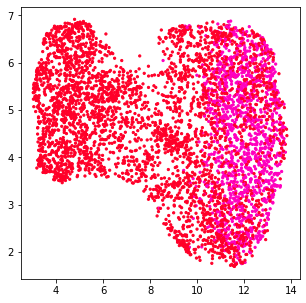

In [14]:
%matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.scatter(embeddings[:,0], embeddings[:,1], s=5, c=labelFiles[:], cmap='gist_rainbow')

In [15]:
toc['visualize'] = time.time() - tic

## Train/Holdout Split

In [16]:
# from sklearn.model_selection import train_test_split
# train_inx, holdout_inx = train_test_split(np.arange(latents.shape[0]), test_size=0.3)

# from sklearn.model_selection import train_test_split
# train_inx, holdout_inx = train_test_split(np.arange(latents.shape[0]), test_size=0.3)

train_inx, holdout_inx = pipeline.stratified_sample(latents, labelFiles, test_size=0.3)[0]

In [17]:
features_train, features_holdout, labels_train, labels_holdout = (latents[train_inx],
                                                                  latents[holdout_inx],
                                                                  labelFiles[train_inx],
                                                                  labelFiles[holdout_inx],)

# Create Pipeline / Classifier

In [18]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

preproc = make_pipeline(
    StandardScaler(),
    PCA(),
)

preproc.fit(features_train, labels_train)

Pipeline(steps=[('standardscaler', StandardScaler()), ('pca', PCA())])

# Cross-Validation

In [19]:
splitter = ShuffleSplit(n_splits=10)
cv = crossval.CrossValidation(splitter)
cv.split_to_inx(features_train)
cv.inx_to_data(features_train, labels_train)

In [20]:
classifier_kwargs = dict(solver='lbfgs', fit_intercept=True,  class_weight='balanced', max_iter=10000)
cv_dct = crossval.split_loop_c(cv, preproc, classifier_kwargs, preproc_refit=False, c_lst=[100, 10, 1, 0.1, 0.01, 0.001])

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

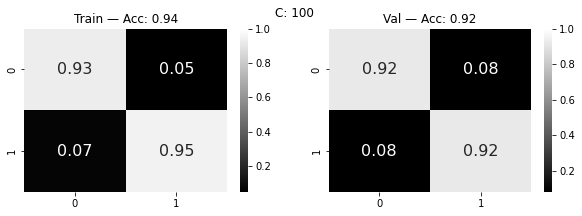

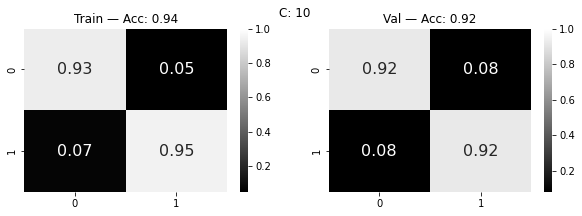

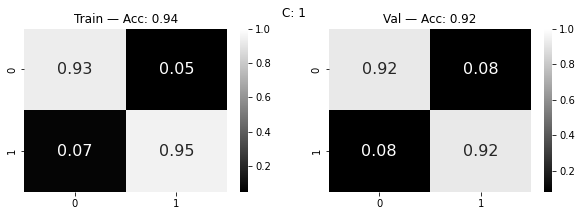

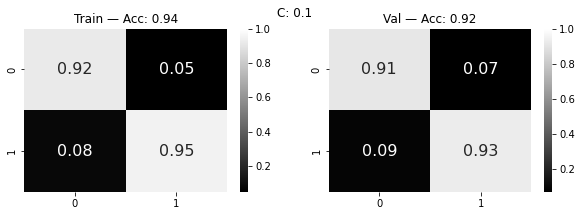

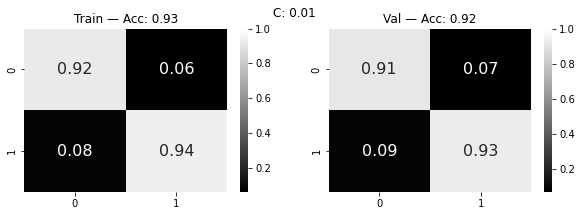

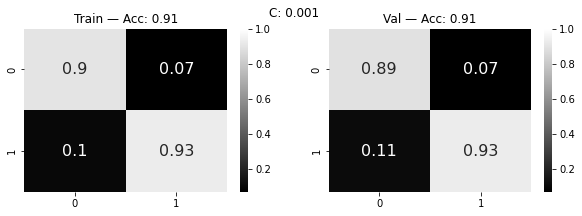

In [21]:
crossval.view_cv_dict(cv_dct)

# Refit Classifier

In [22]:
preproc = make_pipeline(
    StandardScaler(),
    PCA(),
)

classify = LogisticRegression(
    solver='lbfgs',
    fit_intercept=True, 
    class_weight='balanced',
    max_iter=10000,
    C=0.1
)


pipe = pipeline.fit_pipe(features_train, labels_train, preproc, classify, preproc_refit=True)

# Evaluate Classifier

Text(0.5, 0.98, 'Train')

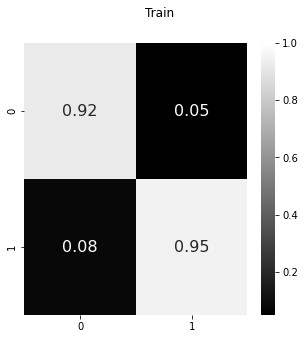

In [23]:
evaluator = evaluate.Evaluation(pipe.pipeline)
cm = evaluator.confusion_matrix(features_train, labels_train)
cm = np.round(cm, 2)
fig, ax = plt.subplots(1, 1, figsize=(5,5))
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, vmax=1., cmap=plt.get_cmap('gray'), ax=ax)
fig.suptitle('Train')

Text(0.5, 0.98, 'Holdout')

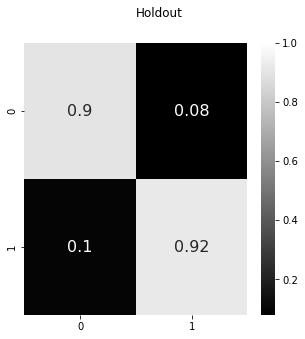

In [24]:
evaluator = evaluate.Evaluation(pipe.pipeline)
cm = evaluator.confusion_matrix(features_holdout, labels_holdout)
cm = np.round(cm, 2)
fig, ax = plt.subplots(1, 1, figsize=(5,5))
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, vmax=1., cmap=plt.get_cmap('gray'), ax=ax)
fig.suptitle('Holdout')

# Refit Model with Different Numbers of Examples

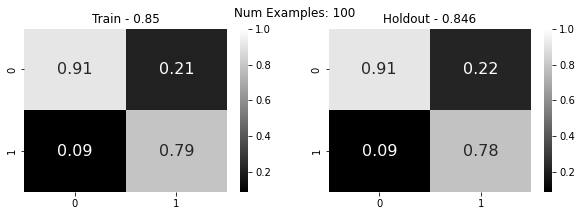

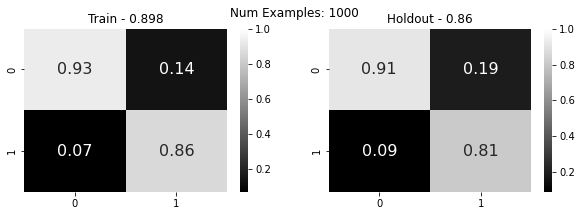

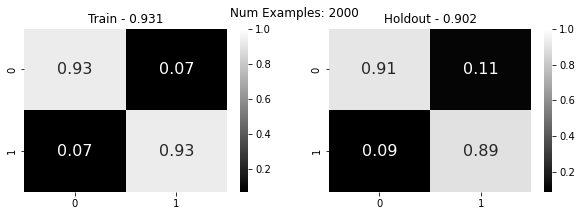

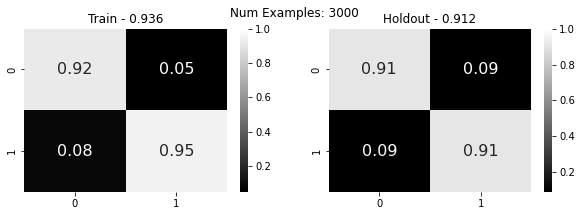

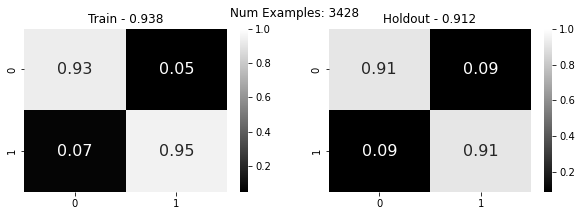

In [29]:
preproc = make_pipeline(
    StandardScaler(),
    PCA(),
)

classify = LogisticRegression(
    solver='lbfgs',
    fit_intercept=True, 
    class_weight='balanced',
    max_iter=10000,
    C=100
)

tr_acc_res, val_acc_res = [], []
# n_train_lst = [1e1, 1e2, 1e3, 2e3, 3e3, 4e3]
n_train_lst = [1e2, 1e3, 2e3, 3e3, 4e3]

for n_train in n_train_lst:
    tr_cm_lst, val_cm_lst, tr_acc_lst, val_acc_lst = [], [], [], []
    for train_inx, holdout_inx in pipeline.stratified_sample(latents, labelFiles, n_splits=100, test_size=0.3):
        
        features_train_nt, labels_train_nt, features_holdout_nt, labels_holdout_nt, = (latents[train_inx], labelFiles[train_inx],
                                                                                       latents[holdout_inx], labelFiles[holdout_inx])
        
        pipe, n_train = pipeline.fit_n_train(features_train_nt, labels_train_nt, preproc, classify, preproc_refit=True, n_train=n_train)

        evaluator = evaluate.Evaluation(pipe.pipeline)
        cm = evaluator.confusion_matrix(features_train_nt, labels_train_nt)
        tr_cm_lst.append(cm)
        acc = evaluator.score_classifier_logreg(features_train_nt, labels_train_nt)
        tr_acc_lst.append(acc)

        evaluator = evaluate.Evaluation(pipe.pipeline)
        cm = evaluator.confusion_matrix(features_holdout_nt, labels_holdout_nt)
        cm = np.round(cm, 2)
        val_cm_lst.append(cm)
        acc = evaluator.score_classifier_logreg(features_holdout_nt, labels_holdout_nt)
        val_acc_lst.append(acc)
        
    
    fig, ax = plt.subplots(1, 2, figsize=(10,3))
    fig.suptitle(f'Num Examples: {int(n_train)}')

    tr_cm = np.round(np.mean(tr_cm_lst, axis=0),2)
    tr_acc = np.round(np.mean(tr_acc_lst, axis=0),3)
    
    sns.heatmap(tr_cm, annot=True, annot_kws={"size": 16}, vmax=1., cmap=plt.get_cmap('gray'), ax=ax[0])
    ax[0].set_title(f'Train - {tr_acc}')
    tr_acc_res.append(tr_acc)
    
    val_cm = np.round(np.mean(val_cm_lst, axis=0),2)
    val_acc = np.round(np.mean(val_acc_lst, axis=0),3)
    
    sns.heatmap(val_cm, annot=True, annot_kws={"size": 16}, vmax=1., cmap=plt.get_cmap('gray'), ax=ax[1])
    ax[1].set_title(f'Holdout - {val_acc}')
    val_acc_res.append(val_acc)
    

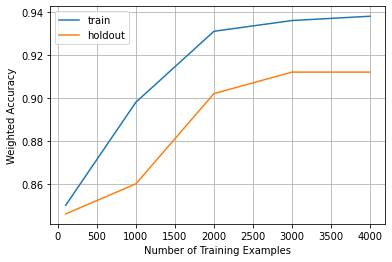

In [30]:
plt.figure()
plt.plot(n_train_lst,tr_acc_res,label='train')
plt.plot(n_train_lst,val_acc_res,label='holdout')
plt.xlabel('Number of Training Examples')
plt.ylabel('Weighted Accuracy')
plt.legend()
plt.grid(True)

# Save Classifier After Refitting to All Data

In [31]:
preproc = make_pipeline(
    StandardScaler(),
    PCA(),
)

classify = LogisticRegression(
    solver='lbfgs',
    fit_intercept=True, 
    class_weight='balanced',
    max_iter=10000,
    C=0.1
)

pipe = pipeline.fit_pipe(latents, labelFiles, preproc, classify, preproc_refit=True)

In [32]:
# Save Pipeline
# pipe.save('/Users/josh/Downloads/data_backup_save/pipe2.pkl')
pipe.save('/n/data1/hms/neurobio/sabatini/josh/analysis/data_backup_save/pipe_update.pkl')

FileNotFoundError: [Errno 2] No such file or directory: '/n/data1/hms/neurobio/sabatini/josh/analysis/data_backup_save/pipe_update.pkl'

In [ ]:
l = np.load('/Users/josh/Downloads/stat.npy', allow_pickle=True)

In [ ]:
l